# Regresión Lineal - Recargado

En este notebook pondrás en práctiva la aplicación de modelos de regresión lineal a problemas no lineales. También incroporarás la técnica de regularización para evitar el overfitting, un problema común en este tipo de enfoques.


## 1. Regresión No-Lineal

Vamos a comenzar, como siempre hacemos en estos temas, con un ejemplo controlado. Supongamos que tenenos un dataset con dos atributos, $x$ e $y$, y la relación entre ellos es $y = -2x^4+3x^2+1$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

La siguiente celda genera nuestro dataset sintético. Le sumamos ruido para simular una situación más realista.

In [2]:
n = 300
x = np.linspace(-1,1,n)
y_real = -1.5*x**4+3*x**2+1
y = y_real + 0.1*np.random.randn(n)

Graficamos la muestra y la curva teórica.

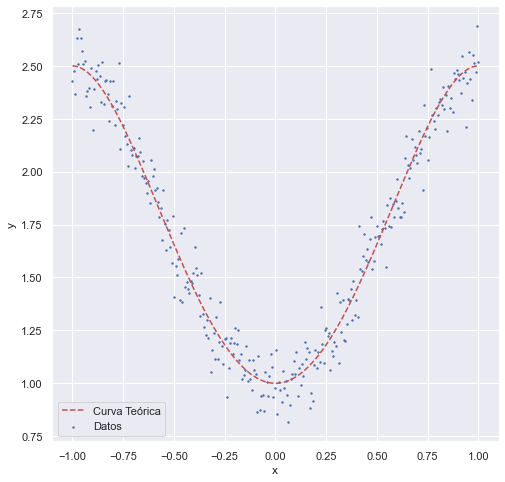

In [3]:
plt.figure(figsize=(8,8))
plt.scatter(x,y, s = 2, label = 'Datos')
plt.plot(x, y_real, '--',label ='Curva Teórica', c = 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Vamos a entrenar un modelo de Regresión Lineal, al que llamaremos `reg_1`. Primero, vamos a definir nuestro dataset `X` (notar la diferencia con la variable `x`)- Luego, hacer un `train_test_split`, y entrenar la regresión lineal.

In [4]:
X = x.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [5]:
reg_1 = LinearRegression()

In [6]:
reg_1.fit(X_train, y_train)

LinearRegression()

In [7]:
y_train_pred_1 = reg_1.predict(X_train)
y_test_pred_1 = reg_1.predict(X_test)

Graficamos la regresión obtenida.

<Figure size 576x576 with 0 Axes>

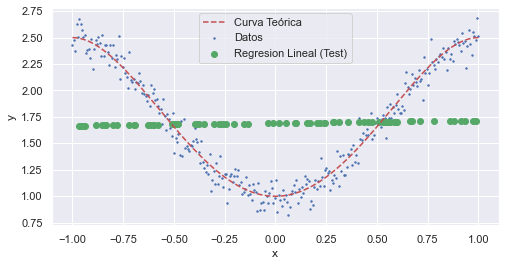

In [8]:
plt.figure(figsize=(8,8))
plt.figure(figsize = (8,4))
plt.scatter(x,y, s = 2, label = 'Datos')
plt.plot(x, y_real, '--',label ='Curva Teórica', c = 'r')
plt.scatter(X_test,y_test_pred_1,label ='Regresion Lineal (Test)', c = 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Ya en el gráfico podemos ver que la regresión obtenida es un modelo malo, ya que no captura correctamente la relación entre $x$ e $y$, salvo por, prácticamente, su valor medio.

De todas formas, calculamos el error RMSE, hacemos un histograma de los errores en el conjunto de Train y Test, y una curva `y` vs `y_pred`

Raíz del error cuadrático medio en Train: 0.5373990088474305
Raíz del error cuadrático medio en Test: 0.5287260520519863


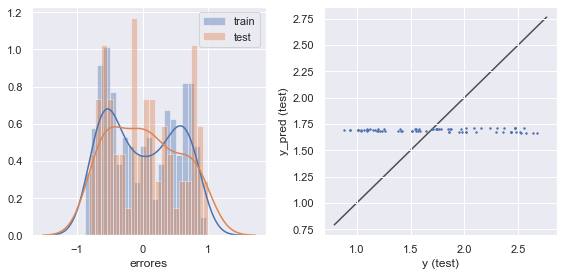

In [9]:

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_1))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_1))
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_1, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_1, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_1, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

plt.tight_layout()
plt.show()

Tal cómo sucedió en ejemplo de la bitácora, el modelo parece muy lejos de la realidad. Veamos si lo podemos mejorar.

Para facilitar la comprensión del código, vamos a crear una función que nos sirva para evaluar modelos de regresión.

In [11]:
def evaluar_regresion(model,x,y, X_train, X_test, y_train, y_test, X_train_new = np.NaN, X_test_new = np.NaN, opcion='N'):
    if(opcion=='N'):
        X_train_new = X_train
        X_test_new = X_test
        
    y_train_pred = model.predict(X_train_new)
    y_test_pred = model.predict(X_test_new)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (12,4))
    plt.subplot(1,3,1)
    if(x.shape[1] == 1):
        plt.scatter(x,y, s = 2, label = 'Datos')
        plt.plot(x, y_real, '--',label ='Curva Teórica', c = 'r')
    
    list1, list2 = zip(*sorted(zip(X_train[:,0], y_train_pred)))
    plt.plot(list1, list2,label ='Regresión (train)')
    
    list1, list2 = zip(*sorted(zip(X_test[:,0], y_test_pred)))
    plt.plot(list1, list2,label = 'Regresión (test)')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()


    plt.subplot(1,3,2)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,3,3)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

### 1.2 Atributos Polinómicos


Vamos a agregar al dataset, `X`, nuevos atributos polinómicos: $x^2, x^3$ y $x^4$  y volver a ajustar la regresión lineal.

Cada atributo lo vamos a agregar de a uno, y vamos a ver cómo se modifica la regresión. **Presta mucha atención al código**. Al agregar un atributo nuevo, ¿qué ocurría con la regresíon lineal?

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia x**1
Los atributos tienen forma: (300, 1)
Coeficientes [0.02494082]
Intercept:  1.6913566970312792
Raíz del error cuadrático medio en Train: 0.5373990088474305
Raíz del error cuadrático medio en Test: 0.5287260520519863


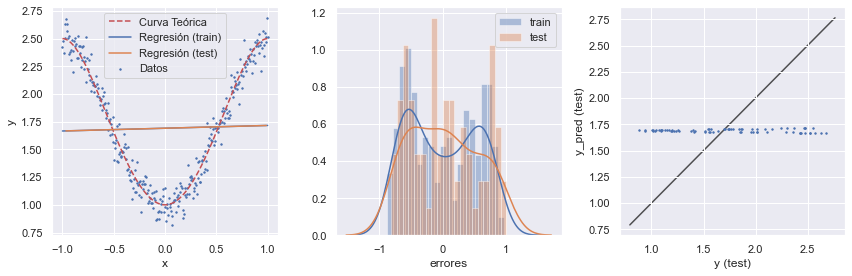

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia x**2
Los atributos tienen forma: (300, 2)
Coeficientes [2.40027173e-04 1.69750159e+00]
Intercept:  1.1214150101908096
Raíz del error cuadrático medio en Train: 0.15396880627453693
Raíz del error cuadrático medio en Test: 0.15116883312205612


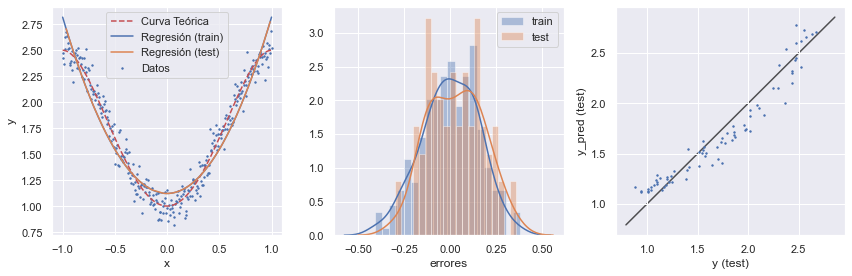

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia x**3
Los atributos tienen forma: (300, 3)
Coeficientes [-0.01181681  1.6974973   0.01976781]
Intercept:  1.121352151087867
Raíz del error cuadrático medio en Train: 0.1539402268676437
Raíz del error cuadrático medio en Test: 0.15169239784624386


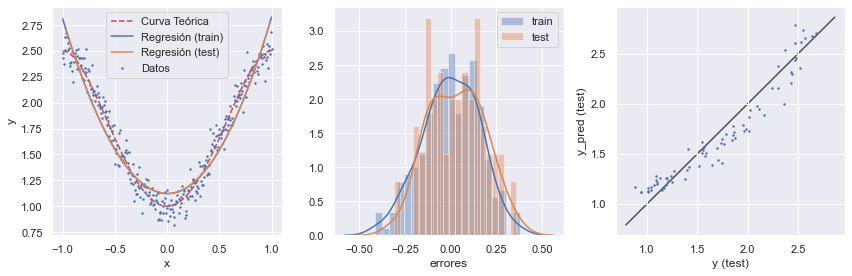

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 4
Agregamos atributos hasta la potencia x**4
Los atributos tienen forma: (300, 4)
Coeficientes [-0.00538695  3.0278621   0.00858818 -1.55651273]
Intercept:  0.9934635137877659
Raíz del error cuadrático medio en Train: 0.09609893284684154
Raíz del error cuadrático medio en Test: 0.10287615965631162


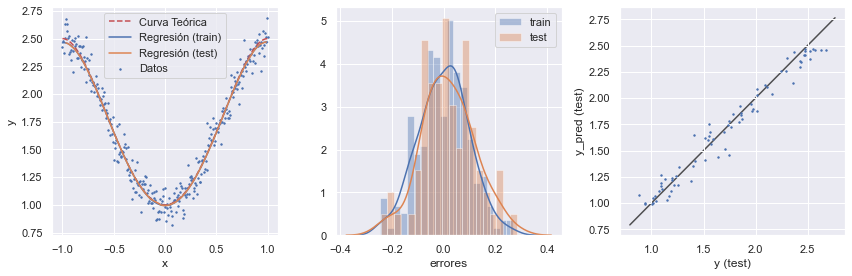

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 5
Agregamos atributos hasta la potencia x**5
Los atributos tienen forma: (300, 5)
Coeficientes [ 0.04885359  3.02784557 -0.24048567 -1.5559559   0.22242204]
Intercept:  0.9935654913538037
Raíz del error cuadrático medio en Train: 0.0956932288376765
Raíz del error cuadrático medio en Test: 0.10306467481433754


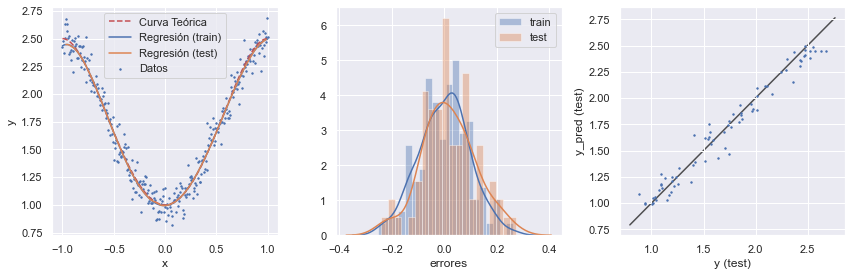

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 6
Agregamos atributos hasta la potencia x**6
Los atributos tienen forma: (300, 6)
Coeficientes [ 0.04866239  3.13185421 -0.23846865 -1.86269251  0.22078654  0.2217382 ]
Intercept:  0.988764239558288
Raíz del error cuadrático medio en Train: 0.09559139160882983
Raíz del error cuadrático medio en Test: 0.10313458602106147


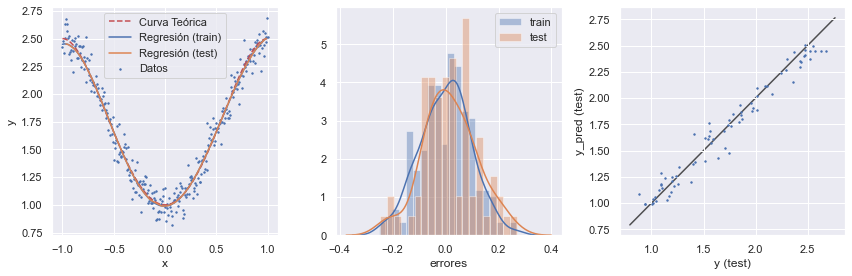

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 7
Agregamos atributos hasta la potencia x**7
Los atributos tienen forma: (300, 7)
Coeficientes [ 0.04386542  3.13254512 -0.19509689 -1.86438503  0.12638628  0.22288922
  0.05772216]
Intercept:  0.9887234318173874
Raíz del error cuadrático medio en Train: 0.09558969955324208
Raíz del error cuadrático medio en Test: 0.1030225333201735


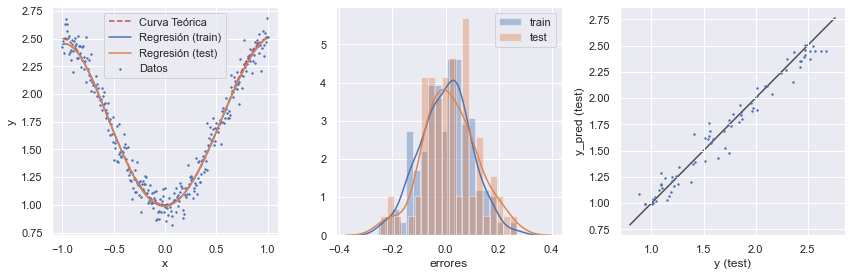

In [11]:
for idx,potencia_maxima in enumerate(range(1,8)):
    print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {idx + 1}')
    print(f'Agregamos atributos hasta la potencia x**{potencia_maxima}')
    
    X = x.reshape(-1,1)
    for potencia in range(2,potencia_maxima+1):
        X = np.hstack((X,(x**potencia).reshape(-1,1)))
    print(f'Los atributos tienen forma: {X.shape}')
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    
    ### ENTRENAMOS
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    print('Coeficientes',reg.coef_)
    print('Intercept: ', reg.intercept_)
    
    ### COMPLETAR AQUI PARA RESOLVER CHALLENGE
    
    evaluar_regresion(reg, x,y, X_train, X_test, y_train, y_test)


Una aclaración sobre el código: es una buena práctica estandarizar los datos (normalizar) antes de entrenar una regresión lineal. No lo hicimos para no saturar (aún más) la explicación.


**Para Pensar - Challenge**

1. ¿Por que no parecen haber cambios entre el segundo y el tercer gráfico?¿Y entre el cuarto y el quinto?
2. Modifica el código de forma tal que imprima los coeficientes (pendientes y ordenada al origen) de cada regresión entrenada.
3. Agrega atributos de orden polinómico más alto y observa qué sucede. **Nota:** la modificación que tienes que hacer en el código es mínima. No tengas miedo de probar diferentes órdenes de magnitud.

## 2. `PolynomialFeatures`

En la práctica, no deberás agregar atributos polinómicos como hicimos en el ejemplo anterior, sino que podrás usar la clase `PolynomialFeatures` de Scikit-Learn. Lee atentamente su documentación y aplícala en el mismo problema de la sección 1. Nosotros te guiamos en los pasos, pero si crees que no lo necesitas, puedes hacerlo en un notebook aparte o borrar las celdas con indicaciones.

**Atención:** Recordá que en estos ejercicios conocemos la forma real de los datos (el polinomio) porque los generamos nosotros. En la realidad no lo vas a conocer, por lo que el grado máximo a incoporar es un hiperparámetro.

1. Importa la clase `PolynomialFeatures`.

2. Vuelve a definir `X` a partir de `x`, y haz un `train_test_split`.

In [13]:
X = x.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

3. Crea un objeto a partir de `PolynomialFeatures` de suficiente `degree` para este problema. Aplícalo sobre `X_train` e `X_test`. Imprime en pantalla el `shape` de los nuevos conjuntos obtenidos.

In [14]:
poly = PolynomialFeatures(2,include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train_new.shape, X_train.shape)
print(X_test_new.shape, X_test.shape)

(225, 2) (225, 1)
(75, 2) (75, 1)


4. Entrena una regresión lineal, observa los coeficientes obtenidos, y predice sobre el conjunto de Train y de Test.

In [15]:
reg_2 = LinearRegression()
reg_2.fit(X_train_new,y_train)
print(reg_2.coef_, reg_2.intercept_)
y_train_pred_2 = reg_2.predict(X_train_new)
y_test_pred_2 = reg_2.predict(X_test_new)

[2.40027173e-04 1.69750159e+00] 1.1214150101908096


5. Calcula el error RMSE sobre cada conjunto, grafica la curva obtenida, el histograma de los errores y la relación $y$ vs. $y_{pred}$ como hicimos en los ejemplos anteriores.

Raíz del error cuadrático medio en Train: 0.15396880627453693
Raíz del error cuadrático medio en Test: 0.15116883312205612


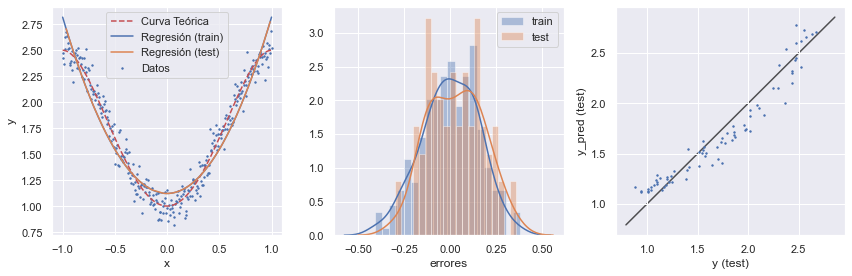

In [16]:
 evaluar_regresion(reg_2, x,y, X_train, X_test, y_train, y_test,X_train_new, X_test_new,'s')

Grado: 1
(225, 1) (225, 1)
[0.02494082] 1.6913566970312792
Raíz del error cuadrático medio en Train: 0.5373990088474305
Raíz del error cuadrático medio en Test: 0.5287260520519863


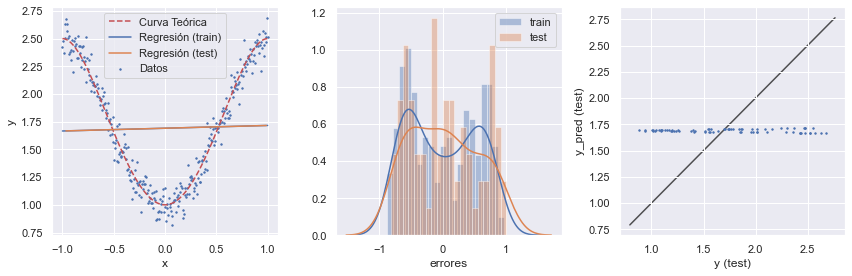

Grado: 2
(225, 2) (225, 1)
[2.40027173e-04 1.69750159e+00] 1.1214150101908096
Raíz del error cuadrático medio en Train: 0.15396880627453693
Raíz del error cuadrático medio en Test: 0.15116883312205612


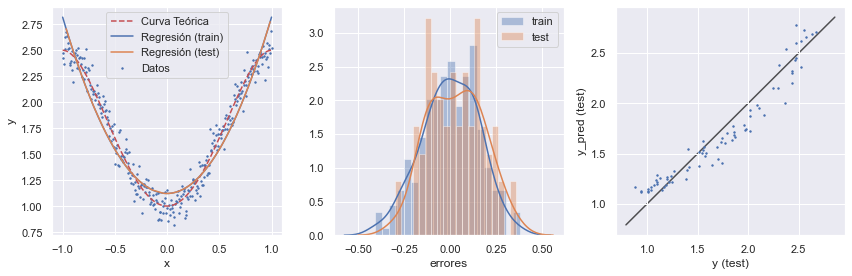

Grado: 3
(225, 3) (225, 1)
[-0.01181681  1.6974973   0.01976781] 1.121352151087867
Raíz del error cuadrático medio en Train: 0.1539402268676437
Raíz del error cuadrático medio en Test: 0.15169239784624386


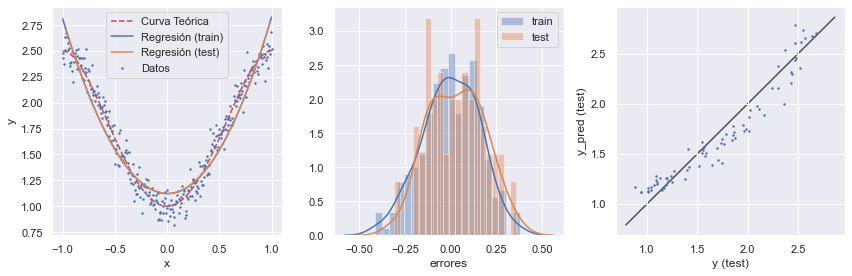

Grado: 4
(225, 4) (225, 1)
[-0.00538695  3.0278621   0.00858818 -1.55651273] 0.9934635137877659
Raíz del error cuadrático medio en Train: 0.09609893284684153
Raíz del error cuadrático medio en Test: 0.10287615965631162


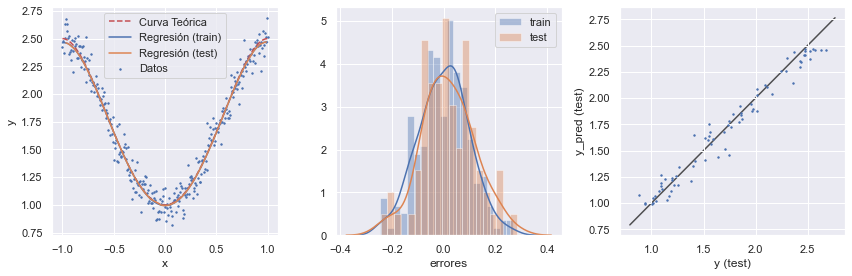

Grado: 5
(225, 5) (225, 1)
[ 0.04885359  3.02784557 -0.24048567 -1.5559559   0.22242204] 0.9935654913538046
Raíz del error cuadrático medio en Train: 0.09569322883767648
Raíz del error cuadrático medio en Test: 0.10306467481433766


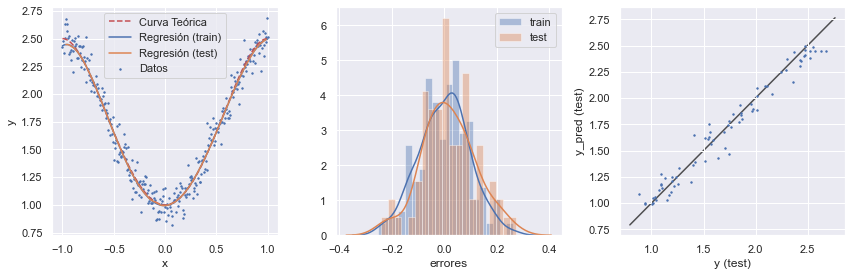

Grado: 6
(225, 6) (225, 1)
[ 0.04866239  3.13185421 -0.23846865 -1.86269251  0.22078654  0.2217382 ] 0.9887642395582883
Raíz del error cuadrático medio en Train: 0.09559139160882983
Raíz del error cuadrático medio en Test: 0.10313458602106146


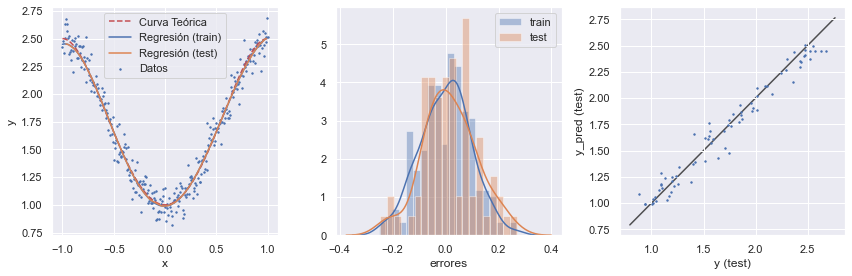

Grado: 7
(225, 7) (225, 1)
[ 0.04386542  3.13254512 -0.19509689 -1.86438503  0.12638628  0.22288922
  0.05772216] 0.9887234318173874
Raíz del error cuadrático medio en Train: 0.0955896995532421
Raíz del error cuadrático medio en Test: 0.10302253332017323


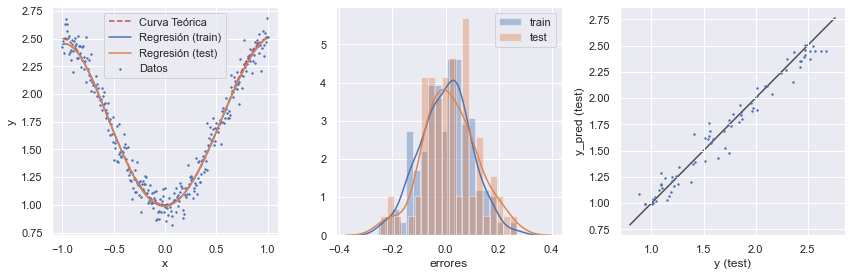

Grado: 8
(225, 8) (225, 1)
[ 0.04440856  2.8392216  -0.19222389 -0.25003757  0.11078744 -2.56075421
  0.07187328  1.48011806] 0.9965880815349358
Raíz del error cuadrático medio en Train: 0.09529041672925515
Raíz del error cuadrático medio en Test: 0.10372765831912147


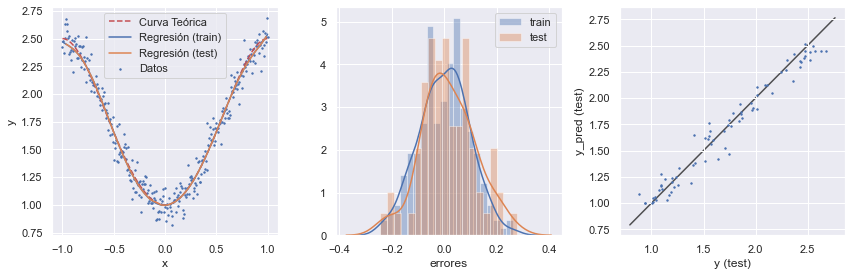

Grado: 9
(225, 9) (225, 1)
[ 0.00963947  2.84163731  0.31108239 -0.25596295 -1.81436743 -2.55183539
  2.77632766  1.47397988 -1.25828611] 0.9963804679063409
Raíz del error cuadrático medio en Train: 0.09523678121063801
Raíz del error cuadrático medio en Test: 0.10357055182197447


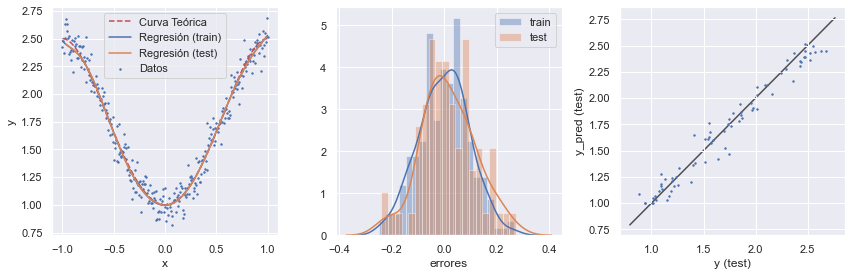

In [17]:
X = x.reshape(-1,1)
for i in range(1,10):
    print('Grado:',i)
    
    poly = PolynomialFeatures(i,include_bias=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    X_train_new = poly.fit_transform(X_train)
    X_test_new = poly.fit_transform(X_test)
    
    print(X_train_new.shape, X_train.shape)
    
    reg_2 = LinearRegression()
    reg_2.fit(X_train_new,y_train)
    print(reg_2.coef_, reg_2.intercept_)
    y_train_pred_2 = reg_2.predict(X_train_new)
    y_test_pred_2 = reg_2.predict(X_test_new)
    
    evaluar_regresion(reg_2, x,y, X_train, X_test, y_train, y_test,X_train_new, X_test_new,'y')

### 3. Regularización

Esperamos haberte convencido de que crear nuevos atributos funciona. Sin embargo, este ejemplo que te mostramos es demasiado sencillo por varios motivos:
1. La relación entre los atributos y la variable a predecir es un polinomio de grado relativamente bajo. No solo eso, sino que además la conocemos.
2. Solamente contamos con una sola variable predictora, `x`, cuando en realidad podrían ser más de un atributo. Como mencionamos en la bitácora, cuando agreguemos nuevos atributos, no solamente podemos considerar las potencias de cada atributo, sino también las interacciones - cosas de la forma $x_1 x_2$.

No siempre sabremos hasta qué grado generar atributos ni si usar interraciones entre ellos. Es más, no siempre será un polinomio la relación entre $x$ e $y$, muchas veces directamente no tendremos claro qué tipo de relación es.

Por suerte, los polinomios suelen ser una buena aproximación a otras funciones. Si no funciona, **podemos generar atributos que no sean polinómicos**, pero eso es algo que deberás investigar por tu cuenta si alguna vez lo necesitas. Por ahora, **es suficiente que sepas que los atributos polinómicos no son la única opción, pero suelen ser una opción versátil.**

En lo que respecta al grado hasta el cual debemos agregar atributos, existe una técnica que nos permite controlar el error si nos pasamos un poco. Esta técnica se llama Regularización, y su alcance es mucho mayor que el aquí expuesto. Veamos cómo funciona.

Vamos a usar de referencia el modelo que entrenaste en la sección anterior. Por las dudas, lo vamos a dejar entrenado nuevamente aquí. Es importante que prestes atención a los coeficientes de esta regresión lineal.

Raíz del error cuadrático medio en Train: 0.0955896995532421
Raíz del error cuadrático medio en Test: 0.10302253332017323


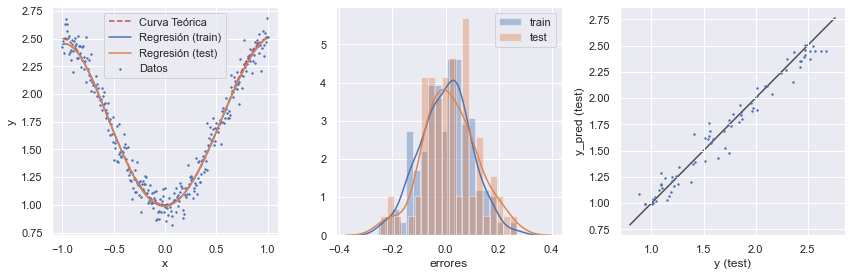

In [18]:
poly = PolynomialFeatures(degree = 7, include_bias=False) ### ACA TENDRAS QUE MODIFICAR MAS ADELANTE
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)

reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train)

evaluar_regresion(reg_2, x,y, X_train_new, X_test_new, y_train, y_test)

Ahora, vamos a entrenar dos regresiones sobre el mismo dataset, pero con regularización. Esto lo puedes hacer con las clases `Ridge` y `Lasso` de Scikit-Learn. Como siempre, es prácticamente obligatorio que consultes su documentación.

Empezamos entrenando el modelo `Ridge`. Presta atención a sus coeficientes:

In [19]:


reg_ridge = Ridge(alpha= 0.1)
reg_ridge.fit(X_train_new,y_train)

print(f'Pendientes: {reg_ridge.coef_}')
print(f'Ordenada: {reg_ridge.intercept_}')

Pendientes: [ 0.02797842  2.50472029 -0.11903513 -0.32801049  0.02344739 -0.7549535
  0.09699101]
Ordenada: 1.02902664284777


Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


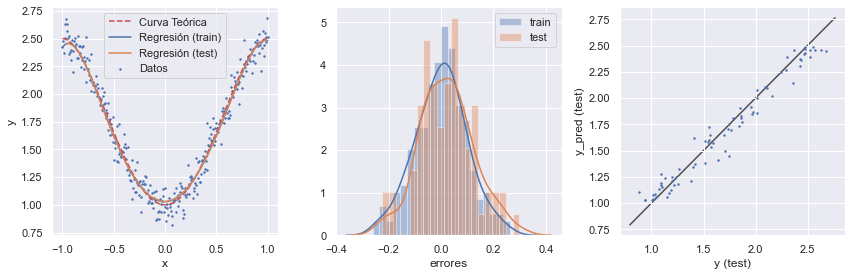

In [20]:
evaluar_regresion(reg_ridge, x,y, X_train_new, X_test_new, y_train, y_test)

**Para Probar:** modifica el valor de `alpha` y observa su efecto. ¿Cómo cambian los coeficientes? **Tip:** varía en órdenes de magnitud,  (10, 5, 1, 0.5, 0.1 ,0.01, 0.005, 0.001, etc.).

Ahora, el modelo `Lasso`:

Alpha: 10
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


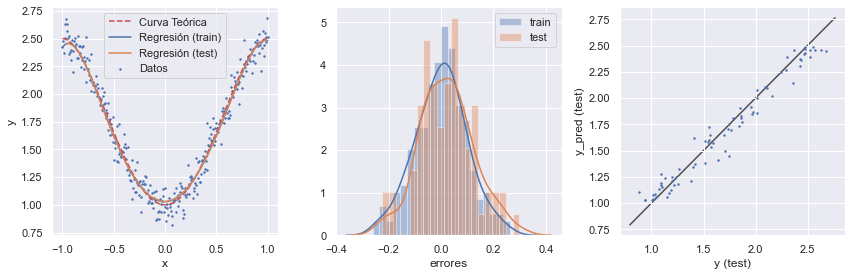

Alpha: 5
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


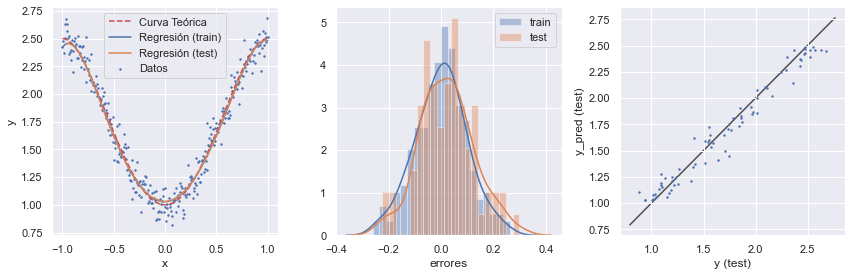

Alpha: 1
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


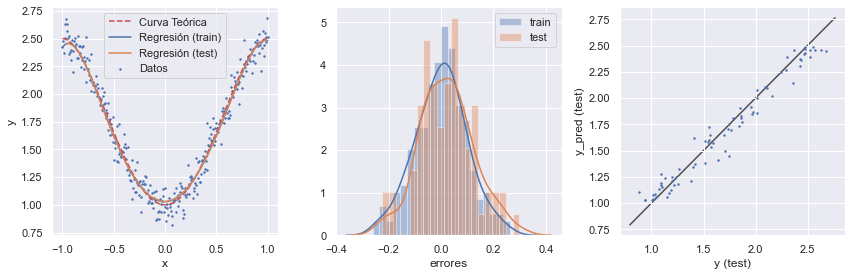

Alpha: 0.5
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


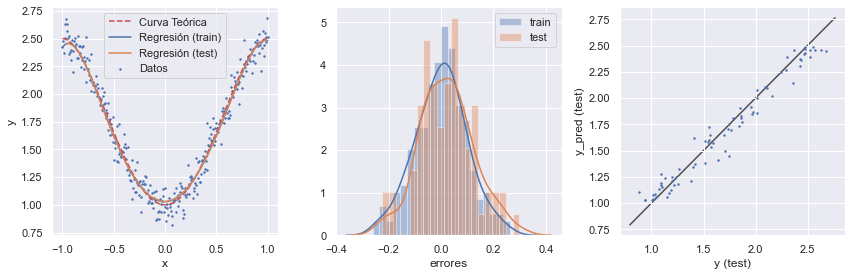

Alpha: 0.1
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


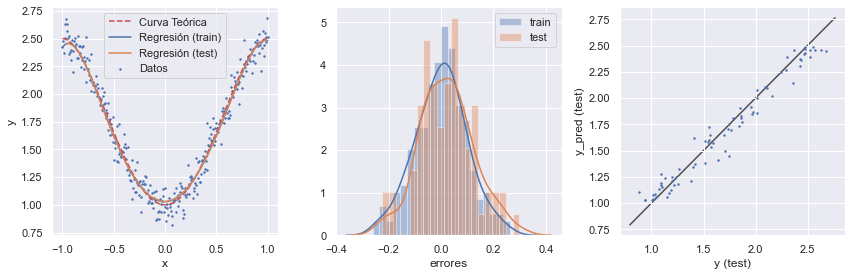

Alpha: 0.01
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


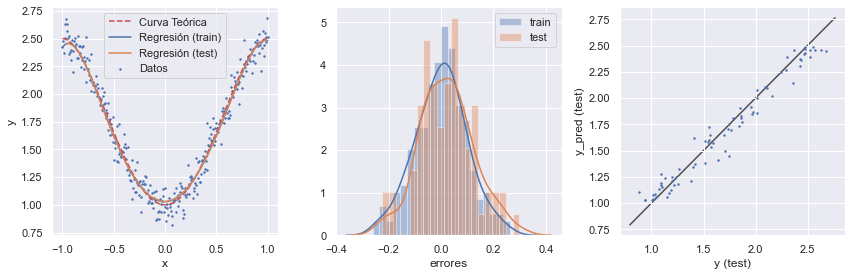

Alpha: 0.005
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


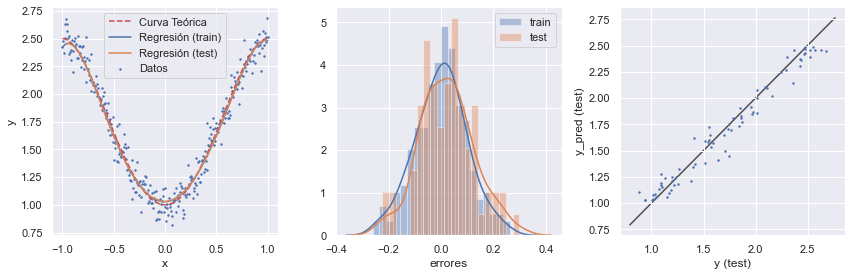

Alpha: 0.001
Raíz del error cuadrático medio en Train: 0.09866999807912802
Raíz del error cuadrático medio en Test: 0.10495951802696823


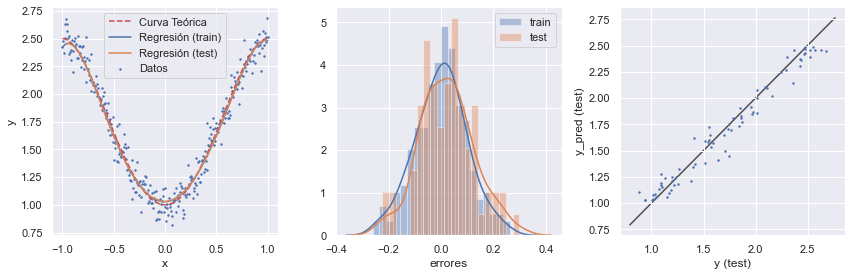

In [21]:
for a in [10, 5, 1, 0.5, 0.1, 0.01, 0.005, 0.001]:
    print('Alpha:',a)
    reg_lasso = Ridge(alpha= a)
    reg_lasso.fit(X_train_new,y_train)
    evaluar_regresion(reg_ridge, x,y, X_train_new, X_test_new, y_train, y_test)

**Para Probar:** nuevamente, modifica el valor de `alpha` y observa su efecto. ¿Cómo cambian los coeficientes?¿Notas alguna diferencia con el modelo `Ridge`? ¡Hay una diferencia importante, que hace que la regresión `Lasso` sea muy apreciada!

**¿Qué pasa por fuera del rango de entrenamiento?**

Estamos entrenando una regresión en un rango de $x$ entre -1 y 1. ¿Pero qué pasa si entrenamos en ese rango, y queremos ver cómo es la regresión por fuera? Es decir, para valores más grandes y más chicos que -1 y 1, respectivamente.

Vamos a usar los modelos obtenidos para predecir por fuera de ese rango. Por las dudas, **reentrena los modelos `ridge` y `lasso` con valores de `alpha` razonables.** Si tuvieras que apostar, ¿cuál modelo te parece más robusto?

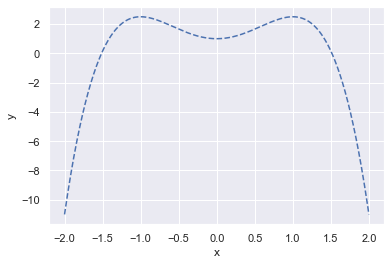

In [22]:
x_nuevo_rango = np.linspace(-2,2,1000)
y_nuevo_rango = -1.5*x_nuevo_rango**4+3*x_nuevo_rango**2+1

plt.plot(x_nuevo_rango, y_nuevo_rango, '--')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [23]:
X_nuevo_rango = poly.fit_transform(x_nuevo_rango.reshape(-1,1))

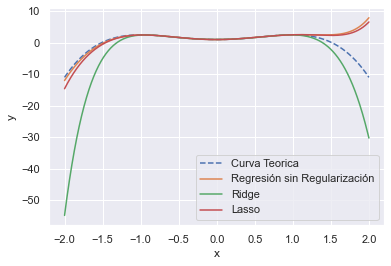

In [24]:
plt.plot(x_nuevo_rango, y_nuevo_rango, '--', label = 'Curva Teorica')
plt.plot(x_nuevo_rango, reg_2.predict(X_nuevo_rango), label = 'Regresión sin Regularización')
plt.plot(x_nuevo_rango, reg_ridge.predict(X_nuevo_rango), label = 'Ridge')
plt.plot(x_nuevo_rango, reg_lasso.predict(X_nuevo_rango), label = 'Lasso')
plt.legend()

### SI NO PUEDE VISUALIZAR CORRECTAMENTE, DESCOMENTA ESTAS LINEAS 
### Y PRUEBA DISTINTOS VALORES PARA LOS LIMITES
# plt.xlim(-2.5,2.5)
# plt.ylim(-10,10)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

Tal vez el ejemplo por ahora no te parezca muy impresionante. De alguna forma, todos los modelos dan resultados muy parecidos. Pero recuerda lo siguiente: nosotros sabemos cómo es la relación funcional de los datos, un polinomio de grado 4. Cuando agregamos atributos, lo estamos haciendo hasta grado 7, lo cual no es mucho más grande que el grado original. 

**Para Probar:** Para ver el verdadero efecto de la regularización, agrega atributos polinómicos hasta un grado alto, por ejemplo 50, 100, 150 ó más. Vuelve a correr la regresión sin regularización, y la regresión Ridge y Lasso, y fíjate qué sucede. Tal vez puedes volver a probar con algunos valores nuevos de `alpha`.


## Conclusiones

Es posible ajustar relaciones no-lineales con un modelo lineal, pero tiene un costo: agregar nuevos atributos. Esto no solo hace crecer de manera considerable nuestro dataset, sino que además introduce un nuevo hiperparámetro, el grado hasta el cual agregamos atributos. Esto se soluciona parcialmente con regularización, pero a costa de otro hiperparámetro, la fuerza de la regularización, $\alpha$. Para colmo, estos hiperparámetros que acabamos de mencionar de alguna forma interactuan: a más atributos agreguemos, $\alpha$ probablemente deba tomar otro valor.

Como si esto no fuera poco, hay que tener mucho cuidado cuando usamos un modelo de regresión entrenado en un rango para predecir por fuera de ese rango. Como verás, las cosas pueden andar muy mal. Por suerte, esto no es un problema en muchas aplicaciones, pero es algo a lo que debes estar atento/a.


## 4. Ejercitación

Si todavía no estás muy cansado/a, puedes intentar hacer algunos de - o todos - los siguientes ejercicios:
1. Experimenta con alguna técnica para visualizar los coeficientes de una regresión, de forma tal de poder observar los efectos de la regularización en ellos.
1. Puedes aplicar lo que vimos hoy en cualquiera de los dos datasets que te dejamos para descargar en la bitácora. Son datasets sintéticos, pero te servirán como práctica más realista de estas herramientas.
1. ¿Recuerdas el Proyecto del Bloque 01? ¡Aplica lo aprendido en ese dataset!

In [3]:
data1 = pd.read_csv("../datasets/DS_Bitácora_23_Data1.csv")

In [4]:
data1.head()

,x1,x2,y
0,3.657861,3.657861,125.494431
1,0.991477,0.991477,32.462018
2,-1.080152,-1.080152,67.165761
3,4.945740,4.945740,156.987642
4,2.540430,2.540430,148.073577


In [5]:
X = data1.drop('y', axis=1)
X = np.array(X)
y = data1['y']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)

Raíz del error cuadrático medio en Train: 210.14233460701905
Raíz del error cuadrático medio en Test: 203.64224424752703


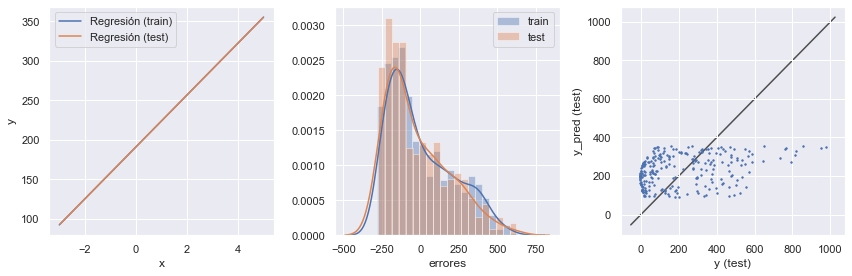

In [12]:
reg = LinearRegression()
reg.fit(X_train,y_train)
predict_train = reg.predict(X_train)
precict_test = reg.predict(X_test)
evaluar_regresion(reg,X,y,X_train,X_test,y_train,y_test)